In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_absolute_error as mae, mean_squared_error as mse
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import os
import sys
# Adicione o caminho do diretório que contém utilsCrosIn.py
import torch

DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"

def asmape(y_true, y_pred, mask=None):
    if mask is not None:
         y_true, y_pred = y_true[mask==1], y_pred[mask==1]
    if type(y_true) is list or type(y_pred) is list:
         y_true, y_pred = np.array(y_true), np.array(y_pred)
    len_ = len(y_true)
    tmp = 100 * (np.nansum(np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))/len_)

    return tmp


class LoaderDataset(Dataset):
    def __init__(self, root_zebra, root_horse, root_masks, chanels=3):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.root_index = root_masks
        
        self.zebra_images = sorted(os.listdir(root_zebra))
        self.horse_images = sorted(os.listdir(root_horse))
        self.index = sorted(os.listdir(root_masks))

        self.length_dataset = max(len(self.zebra_images), len(self.horse_images))
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)
        self.index_len = len(self.index)
        self.chanels = chanels
    
    def __len__(self):
        return self.length_dataset
    
    @staticmethod
    def custom_normalize(image):
      image = torch.tensor(image, dtype=torch.float32)
      # scal= torch.maximum(torch.max(image)-torch.torch.min(image), torch.tensor(1e-5))
      std_val = torch.std(image).clone().detach()
      std_val = torch.maximum(std_val, torch.tensor(1e-5))  # Evita divisão por zero
      mean_val = torch.mean(image).clone().detach()
      image_normalized = (image - mean_val) / (std_val)
      return image_normalized, std_val, mean_val
    

    @staticmethod
    def remover_outliers_imagem(img, fator=1.5):
      """
			Remove outliers de uma imagem aplicando o método do IQR a cada canal de cor.
			
			Parâmetros:
					img (numpy.ndarray): Imagem no formato (altura, largura, canais).
					fator (float): Multiplicador do IQR para definir os limites (padrão 1.5).
					
			Retorna:
					numpy.ndarray: Imagem com outliers suavizados.
			"""
      img_filtrada = img.copy()
			
      for c in range(img.shape[2]):  # Itera sobre os canais (R, G, B)
          canal = img[:, :, c].flatten()  # Achata o canal para 1D

					# Calcula os quartis e o IQR
          Q1 = np.percentile(canal, 25)
          Q3 = np.percentile(canal, 75)
          IQR = Q3 - Q1

					# Define limites de outliers
          limite_inferior = Q1 - fator * IQR
          limite_superior = Q3 + fator * IQR

					# Suaviza outliers substituindo por valores dentro dos limites
          canal = np.clip(canal, limite_inferior, limite_superior)

					# Reestrutura o canal de volta para a forma original
          img_filtrada[:, :, c] = canal.reshape(img[:, :, c].shape)
      
      return img_filtrada



    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]
        index_ids = self.index[index % self.index_len]

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)
        index_path = os.path.join(self.root_index, index_ids)  # Corrigido aqui

        if self.chanels == 3:
            zebra_img = np.load(zebra_path)
            horse_img = np.load(horse_path)
            
            if len(zebra_img.shape)>3:
                zebra_img = zebra_img.reshape(32,32,3)
                horse_img = horse_img.reshape(32,32,3)
                
            mask = np.load(index_path)

            zebra_img = np.transpose(zebra_img, (2, 0, 1))
            horse_img = np.transpose(horse_img, (2, 0, 1))
            
            zebra_img = LoaderDataset.remover_outliers_imagem(zebra_img)
            horse_img = LoaderDataset.remover_outliers_imagem(horse_img)
            
        if self.chanels == 2:
            zebra_img = np.load(zebra_path)
            horse_img = np.load(horse_path)
            if len(zebra_img.shape)>3:
                zebra_img = zebra_img.reshape(32,32,3)
                horse_img = horse_img.reshape(32,32,3)

            mask = np.load(index_path)
        
            zebra_img = np.transpose(zebra_img, (2, 0, 1))
            horse_img = np.transpose(horse_img, (2, 0, 1))

        
            zebra_img = zebra_img[:2, :, :]
            horse_img = horse_img[:2, :, :]
            zebra_img = LoaderDataset.remover_outliers_imagem(zebra_img)
            horse_img = LoaderDataset.remover_outliers_imagem(horse_img)

        if self.chanels == 1: 
            zebra_img = np.load(zebra_path)
            horse_img = np.load(horse_path)
            

            mask = np.load(index_path)

            zebra_img = np.sum(zebra_img, axis=-1)  #  Remove canal extra
            horse_img = np.sum(horse_img, axis=-1)
            zebra_img = np.transpose(zebra_img, (2, 0, 1))
            horse_img = np.transpose(horse_img, (2, 0, 1))
            zebra_img = LoaderDataset.remover_outliers_imagem(zebra_img)
            horse_img = LoaderDataset.remover_outliers_imagem(horse_img)
  

        #  Garante que os tensores estejam no formato correto antes de serem normalizados


        zebra_img, std, media = LoaderDataset.custom_normalize(zebra_img)
        horse_img, _, _ = LoaderDataset.custom_normalize(horse_img)

 
        # print(zebra_img.shape, horse_img.shape)
        mask = torch.tensor(mask, dtype=torch.float32)
       

        return zebra_img, horse_img, std, media, mask

		
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        self.enc1 = self.conv2Relu(in_channels, 32, 5)
        self.enc2 = self.conv2Relu(32, 64, pool_size=4)
        self.enc3 = self.conv2Relu(64, 128, pool_size=2)
        self.enc4 = self.conv2Relu(128, 256, pool_size=2)
        
        self.dec1 = self.deconv2Relu(256, 128, pool_size=2)
        self.dec2 = self.deconv2Relu(128+128, 64, pool_size=2)
        self.dec3 = self.deconv2Relu(64+64, 32, pool_size=4)
        self.dec4 = nn.Sequential(
            nn.Conv2d(32+32, out_channels, 5, padding=2), 
            nn.Tanh()
        )

    def conv2Relu(self, in_c, out_c, kernel_size=3, pool_size=None):
        layer = []
        if pool_size:
            layer.append(nn.AvgPool2d(pool_size))
        layer.append(nn.Conv2d(in_c, out_c, kernel_size, padding=(kernel_size-1)//2))
        layer.append(nn.LeakyReLU(0.2, inplace=False))
        layer.append(nn.BatchNorm2d(out_c))
        layer.append(nn.ReLU(inplace=False))
        return nn.Sequential(*layer)
    
    def deconv2Relu(self, in_c, out_c, kernel_size=3, stride=1, pool_size=None):
        layer = []
        if pool_size:
            layer.append(nn.UpsamplingNearest2d(scale_factor=pool_size))
        layer.append(nn.Conv2d(in_c, out_c, kernel_size, stride, padding=1))
        layer.append(nn.BatchNorm2d(out_c))
        layer.append(nn.ReLU(inplace=False))
        return nn.Sequential(*layer)
    
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)
        out = self.dec1(x4)
        out = self.dec2(torch.cat((out, x3), dim=1))
        out = self.dec3(torch.cat((out, x2), dim=1))
        out = self.dec4(torch.cat((out, x1), dim=1))
        return out 


              
              
# Função de teste
def test(gen_Z, test_loader, taxa, fold, chanells):

    gen_Z.eval()
    amm= []
    bik =[]
    with torch.no_grad():
        # Criar o DataFrame com as colunas desejadas
        df = pd.DataFrame([], columns=['mae', 'asmape', 'mape', 'rmse', 'scale'], index=test_loader.dataset.horse_images)

        for (zebra, horse, std_val, mean_val, mask), name in zip(test_loader, test_loader.dataset.horse_images):

            # Mover dados para o dispositivo
            zebra = zebra.to(DEVICE)
            horse = horse.to(DEVICE)

            # Converter std_val e mean_val para tensores e movê-los para o dispositivo
            std_val = torch.tensor(std_val, device=DEVICE) if not isinstance(std_val, torch.Tensor) else std_val.to(DEVICE)
            mean_val = torch.tensor(mean_val, device=DEVICE) if not isinstance(mean_val, torch.Tensor) else mean_val.to(DEVICE)

            # Gerar fake_zebra usando o gerador
            fake_zebra = gen_Z(horse)

            # Mover apenas as imagens para a CPU antes de operações subsequentes
            zebra = zebra.cpu()
            fake_zebra = fake_zebra.cpu()

            # Voltar para escala original 
            zebra = zebra * std_val.cpu() + mean_val.cpu()
            fake_zebra = fake_zebra * std_val.cpu() + mean_val.cpu()

            # Somar sobre o canal e achatar as imagens
            zebra = torch.sum(zebra, dim=1).flatten()
            fake_zebra = torch.sum(fake_zebra, dim=1).flatten()

            # Certificar que zebra e fake_zebra estão na CPU e sem gradientes antes de usar métricas
            zebra_np = zebra * mask
            fake_zebra_np = fake_zebra * mask

            # Calcular as métricas corretamente
            mae_value = round(mae(zebra_np, fake_zebra_np), 3)
            mape_value = round(mape(zebra_np, fake_zebra_np) * 100, 3)
            rmse_value = round(np.sqrt(mse(zebra_np, fake_zebra_np)), 3)
            smape_value = round(asmape(zebra_np, fake_zebra_np, mask), 3)

            # Adicionar os resultados ao DataFrame
            df.loc[name] = [mae_value, smape_value, mape_value, rmse_value, np.max(zebra.numpy()) - np.min(zebra.numpy())]

            zebra_list = zebra_np.cpu().detach().numpy().flatten().tolist()
            fake_list  = fake_zebra_np.cpu().detach().numpy().flatten().tolist()

            if name[:3]=='amm':
                for z, f in zip(zebra_list, fake_list):
                    amm.append([z, f])
            elif name[:3]=='Bik':
                for z, f in zip(zebra_list, fake_list):
                    bik.append([z, f])

        # Salvar o DataFrame em um arquivo CSV
        directory = "./resultados/resultados_pix"
        if not os.path.exists(directory):
            os.makedirs(directory)

        df.to_csv(os.path.join(directory, f'result_{str(chanells)}c_{taxa}_{fold}.csv'))
    return bik,amm


# Parâmetros de treinamento

BATCH_SIZE = 256


import os

TRAIN_DIR = os.path.abspath("../dataset_final")  
VAL_DIR = os.path.abspath("../dataset_final")  
INDEX_TRAIN = os.path.abspath("../dataset_final")  
INDEX_VAL = os.path.abspath("../dataset_final")  
INDEX_TEST = os.path.abspath("../dataset_final")  

def load_checkpoint(checkpoint_file, model, DEVICE):
    # print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file,weights_only=True, map_location=DEVICE)  # Carrega o estado salvo
    model.load_state_dict(checkpoint)  # Usa diretamente o dicionário de pesos
    return model


  
import multiprocessing as mp
if __name__ == '__main__':
    mp.freeze_support()
    for in_channels in [1]:
        print(f'channel {in_channels}')
        for taxa in ['10','20','30','40']:
          for fold in ['1','2','3','4','5']:  

            test_dataset = LoaderDataset(
                  root_zebra=os.path.join( VAL_DIR, "label", str(taxa), "folds", f"fold{fold}", "test"),
									root_horse=os.path.join( VAL_DIR, "input", str(taxa), "folds", f"fold{fold}", "test"),
									root_masks=os.path.join(INDEX_TEST, "input", str(taxa), "folds", f"fold{fold}", "index"),
									chanels=in_channels
						)
            			
            test_loader = DataLoader( test_dataset,  batch_size=1,shuffle=False,pin_memory=False )
            
            test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)
            generator = Generator(in_channels=in_channels, out_channels=in_channels).to(DEVICE)
            save_dir = f"./models_saved/pix2pix/{in_channels}/{taxa}/fold{fold}"
            model_path = os.path.join(save_dir, "generator.pth")
            load_checkpoint(model_path,generator,DEVICE)
            
            # Teste
            bik, amm = test(generator, test_loader=test_loader, taxa=taxa, fold=fold, chanells=in_channels)
            # Ao final, converta as listas em DataFrames com duas colunas
            df_amm = pd.DataFrame(amm, columns=['real', 'predicted'])
            df_bik = pd.DataFrame(bik, columns=['real', 'predicted'])

channel 1


<Axes: ylabel='Values'>

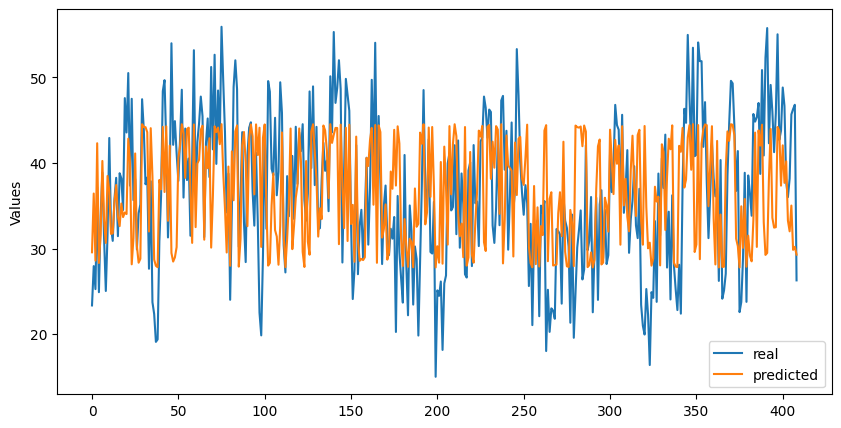

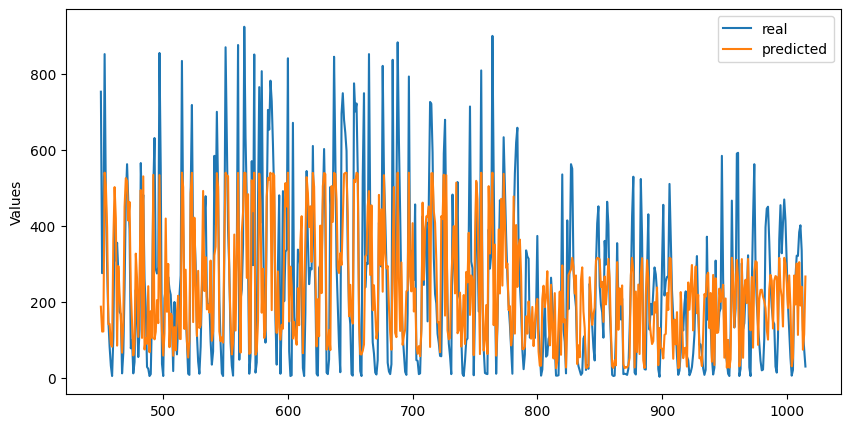

In [52]:
df_filtered = df_amm[(df_amm['real'] != 0) & (df_amm['predicted'] != 0)].reset_index(drop=True)
df_filtered1 = df_bik[(df_bik['real'] != 0) & (df_bik['predicted'] != 0)].reset_index(drop=True)


# Plota o DataFrame filtrado
df_filtered.plot(figsize=(10,5),ylabel='Values')
df_filtered1.iloc[450:-200,:].plot(figsize=(10,5), ylabel='Values')